In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Query NVE's Grid Time Series (GTS) API

NVE has an open API for querying time series from their **1 km resolution gridded historic weather dataset**. The API is documented [here](http://api.nve.no/doc/gridtimeseries-data-gts/) and provides data from 1957 to present.

For a wide range of weather and hydrological parameters, and for any location in Norway, it is possible to query:

 1. Time series for specific points (i.e. values over time for a specific grid cell), and 
 
 2. Spatially aggregated time series for a user-defined area (i.e. the user supplies a polygon and the API returns grid-averaged values for the polygon for each time point)
 
NivaPy's "data access" (`.da`) module includes functions to make it easier to query data via this API. 

**NOTE:** The API endpoint for (2) is currently not working. I have asked NVE about this.

## 1. Get time series for points (i.e. specific grid cells)

### 1.1. Example data

As a starting point, the user must supply a dataframe listing the locations of interest. The dataframe must include columns for the x and y co-ordinates, plus a column with a unique identifier for each location (in other words, each row of the dataframe should have a unique identifier).

Data can be provided in any co-ordinate system you wish, but if the co-ordinates are not WGS84-based lat/lon (the default), you **must remember to explicitly specify the CRS**. The API requires co-ordinates in UTM Zone 33N, so whatever data you provide will first be reprojected to this CRS before submitting the query. This is handled automatically, *as long as you specify the CRS correctly* (see below).

In [2]:
# Read example data from Finnmark
csv_path = "../example_data/quantom_catchment_outlets.csv"
df = pd.read_csv(csv_path, sep=";")
df.head()

,site_id,site_name,outlet_lat,outlet_lon,outlet_elev_m
0,1,Njahkajavri,68.879606,23.761291,480
1,2,Vuomajeaggi,69.016558,24.142340,365
2,3,Juovvajohka,69.091233,24.473330,311
3,4,Caskin-jeaggi / Caskinjohka,68.926158,25.597493,211
4,6,Fáhttevárleakšá,69.594406,25.012381,350


### 1.2. List all available parameters

Get a list of all parameters available via the API.

Note that a `TimeResolutionInMinutes` of 1440 mean **daily** data.

In [3]:
par_df = nivapy.da.get_nve_gts_api_parameters()
par_df

,Name,Fullname,NoDataValue,RawUnit,HumanReadableUnit,TimeResolutionInMinutes,FirstDateInTimeSerie
0,rr,Døgnnedbør v2.0,65535,mm,mm,1440,1957-01-01
1,tm,Døgntemperatur v2.0,65535,Kelvin,Celcius,1440,1957-01-01
4,swe,Snømengde v2.0.1,65535,mm,mm,1440,1957-01-01
5,snowload,Snølast,65535,kg/m2,kg/m2,1440,2000-01-01
6,sd,Snødybde v2.0.1,65535,mm,cm,1440,1957-01-01
7,swepr,Snømengde i prosent v2.0.1,65535,%,%,1440,1957-01-01
8,age,Snøens alder v2.0.1,255,Dager,Dager,1440,1957-01-01
9,qtt,Regn og snøsmelting v2.0.1,255,mm,mm,1440,1957-01-01
10,qtt7d,Regn og snøsmelting siste uke,65535,mm,mm,1440,1957-01-01
11,gwb_q,Avrenning,65535,mm,mm,1440,1957-01-01


### 1.3. Get time series

Choose the parameters of interest from `par_df` above, then pass this to `nivapy.da.get_nve_gts_api_time_series()` along with your dataframe of target locations. Parameters can either be specified as a list (as in the example below), or a filtered dataframe in the same format as `par_df` above. You must also specify your time period of interest.

In [4]:
pars = ["rr", "tm"]
# pars = par_df.query("Name in ['rr', 'tm']") # Sometimes it's useful to pass filtered 'par_df' instead

st_dt = "2010-01-01"
end_dt = "2020-12-31"

res_df = nivapy.da.get_nve_gts_api_time_series(
    df,
    pars,
    st_dt,
    end_dt,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
)
res_df

Looping over parameters:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over stations:   0%|          | 0/21 [00:00<?, ?it/s]

Looping over stations:   0%|          | 0/21 [00:00<?, ?it/s]

,site_id,x_utm_33n,y_utm_33n,altitude_m,par,full_name,unit,time_resolution,datetime,value
0,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-01 06:00:00,0.80
1,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-02 06:00:00,0.40
2,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-03 06:00:00,1.30
3,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-04 06:00:00,0.70
4,1,851298,7666054,492,rr,Døgnnedbør v2.0,mm,1440,2010-01-05 06:00:00,0.10
...,...,...,...,...,...,...,...,...,...,...
4013,10b,989039,7851512,38,tm,Døgntemperatur v2.0,Celcius,1440,2020-12-27 06:00:00,-24.05
4014,10b,989039,7851512,38,tm,Døgntemperatur v2.0,Celcius,1440,2020-12-28 06:00:00,-19.45
4015,10b,989039,7851512,38,tm,Døgntemperatur v2.0,Celcius,1440,2020-12-29 06:00:00,-5.15
4016,10b,989039,7851512,38,tm,Døgntemperatur v2.0,Celcius,1440,2020-12-30 06:00:00,-2.75


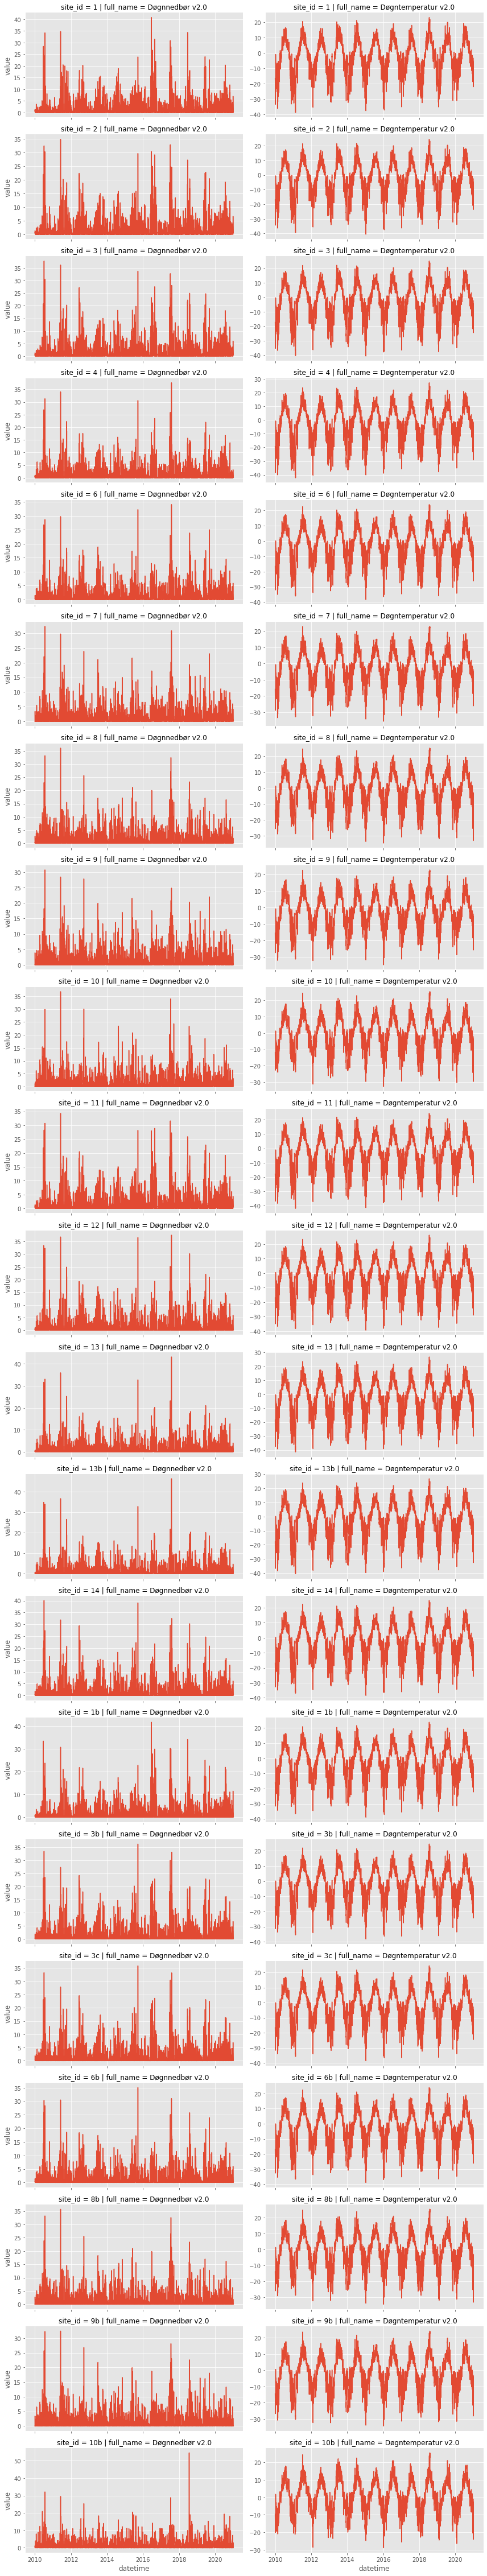

In [5]:
# Plot
g = sn.relplot(
    data=res_df,
    x="datetime",
    y="value",
    col="full_name",
    row="site_id",
    kind="line",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": True},
)

## 2. Get time series for polygons (i.e. aggregate multiple grid cells)

**API endpoint not currently working - I have raised this with NVE**.